In [1]:
import pandas as pd
from PIL import Image
import glob, os
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import shutil
from skimage import io
from sklearn.model_selection import train_test_split
import numpy as np
import random
import sklearn.metrics as metrics
import seaborn as sns
import math
import cv2 as cv

print(f"Tensor Flow Version: {tf.__version__}")

2023-06-22 06:58:01.735216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 06:58:01.760862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 06:58:01.761941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 06:58:02.382345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensor Flow Version: 2.12.0


## Constants

In [2]:
SEED = 123
BATCH_SIZE = 16
IMAGE_SHAPE = (256, 256)
DATASET_DIR = "../../dataset/preprocessed-datasets/preprocessed_roi"
BUFFER_SIZE = 1000
NUM_CLASSES = 1
PATCH_SIZE = 8
NUM_PATCHES = (IMAGE_SHAPE[0] // PATCH_SIZE) ** 2
PROJECTION_DIM = 128
CHECKPOINT = "./checkpoint/transunet_8"

In [3]:
metadata = pd.read_csv("../../dataset/preprocessed-datasets/preprocessed_roi_metadata.csv")
metadata.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../dataset/preprocessed-datasets/preprocessed_roi_metadata.csv'

## Show examples

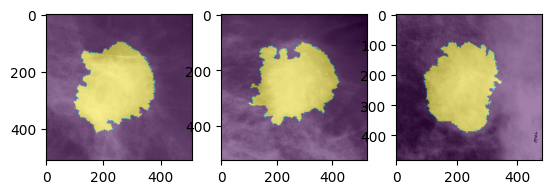

In [8]:
# Show some examples with original and mask
samples = metadata.sample(n=3).reset_index()

for i, sample in samples.iterrows():
    img = cv.imread(f"{DATASET_DIR}/{sample.cropped_img}")
    mask = cv.imread(f"{DATASET_DIR}/{sample.cropped_mask_img}", cv.IMREAD_GRAYSCALE) 

    plt.subplot(1, len(samples), i + 1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.imshow(mask, alpha=0.5)

In [9]:
def augmentation(inputs, labels):
    min, max = (0, 100000)
    seed = random.randint(min, max)
    
    inputs = tf.image.random_flip_left_right(inputs, seed=seed)
    inputs = tf.image.random_flip_up_down(inputs, seed=seed)
    labels = tf.image.random_flip_left_right(labels, seed=seed)
    labels = tf.image.random_flip_up_down(labels, seed=seed)
    
    return inputs, labels

## Split dataset to train, val and test

In [10]:
# Split dataset with sklearn train_test_split
train_df = metadata.query("dataset == 'train'")
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=SEED)
test_df = metadata.query("dataset == 'test'")

print(len(train_df), len(val_df), len(test_df))

1185 132 378


## Create dataset generator

In [11]:
tf.get_logger().setLevel('ERROR')

def show_batch(dataset):
    for images, labels in dataset.take(1):
        for i, data in enumerate(zip(images, labels)):
            plt.subplot(2, len(images) // 2, i + 1)
            img, label = data

            plt.imshow(img)
            plt.imshow(label, alpha=0.2)

2023-05-25 12:49:36.312755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1185,3]
	 [[{{node Placeholder/_1}}]]
2023-05-25 12:49:36.313029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1185,3]
	 [[{{node Placeholder/_0}}]]
2023-05-25 12:49:37.640092: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input

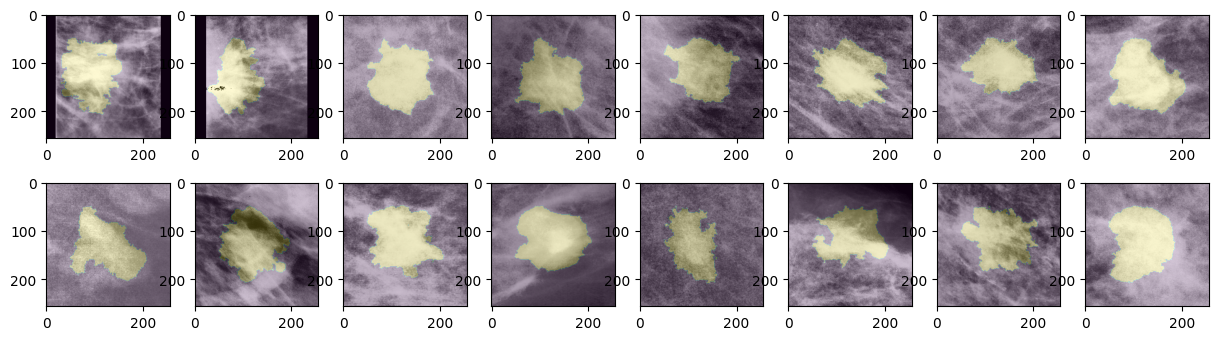

In [12]:
def load_and_preprocess_image(image_data, channels=3):
    image = tf.io.read_file(DATASET_DIR + "/" + image_data[0])
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.resize_with_pad(image, target_height=IMAGE_SHAPE[0], target_width=IMAGE_SHAPE[1], method="nearest")
    return image

def load_image(image_data, mask_name):
    img = load_and_preprocess_image(image_data)
    mask = load_and_preprocess_image(mask_name, channels=1)
    img, mask = tf.cast(img, tf.float32), tf.cast(mask, tf.float32)
    img /= 0xff
    mask /= 0xff
    return img, mask

def create_data_generator(df):
    dataset = tf.data.Dataset.from_tensor_slices(
        ([(row["cropped_img"], str(row["width"]), str(row["height"])) for i, row in df.iterrows()], 
         [(row["cropped_mask_img"], str(row["width"]), str(row["height"])) for i, row in df.iterrows()])
    )
    dataset = dataset.map(load_image).batch(BATCH_SIZE)
    return dataset

train_ds = create_data_generator(train_df).shuffle(buffer_size=BUFFER_SIZE).prefetch(tf.data.AUTOTUNE).cache()
val_ds = create_data_generator(val_df).shuffle(buffer_size=BUFFER_SIZE)
test_ds = create_data_generator(test_df)

plt.figure(figsize=(15, 4))
show_batch(train_ds)

In [4]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [5]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: (256, 256)
Patch size: 8 X 8
Patches per image: 1024
Elements per patch: 192
(1, 1024, 192)


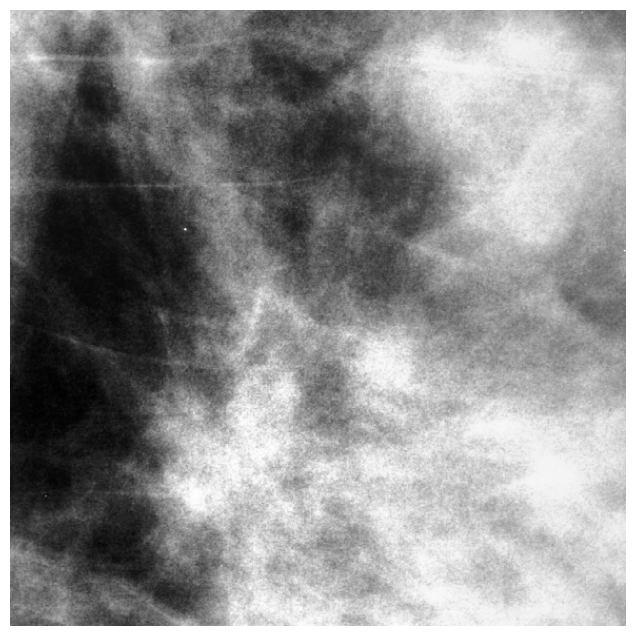

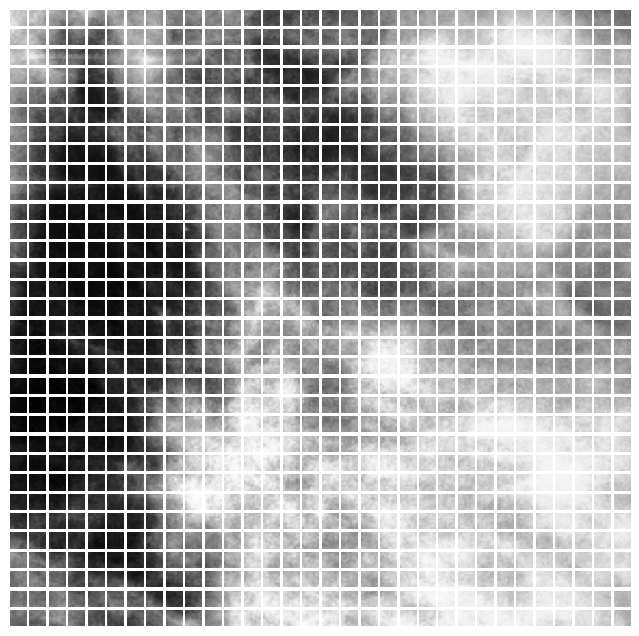

In [14]:
plt.figure(figsize=(8, 8))
image = plt.imread(DATASET_DIR + "/" + train_df.iloc[0].cropped_img)
plt.imshow(image)
plt.axis("off")


resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=IMAGE_SHAPE
)
patches = Patches(PATCH_SIZE)(resized_image)
print(f"Image size: {IMAGE_SHAPE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print(patches.shape)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [6]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## UNet

In [9]:
def conv_block(x, filters, kernel=3):
    x = tf.keras.layers.Conv2D(filters, kernel, activation="relu", padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(filters, kernel, activation="relu", padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    return x

def res_conv_block(x, filters, kernel=3):
    fx = conv_block(x, filters, kernel)
    
    if x.shape != fx.shape:
        x = tf.keras.layers.Conv2D(filters, (1, 1), activation="relu")(x)
        
    out = tf.keras.layers.Add()([x, fx])
    out = tf.keras.layers.ReLU()(out)
    
    return out

def transformer_block(x, num_layers = 8, num_heads = 4):
    patches = Patches(PATCH_SIZE)(x)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)
    
    # Create multiple layers of the Transformer block.
    for _ in range(num_layers):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[PROJECTION_DIM * 2, PROJECTION_DIM], dropout_rate=0.1)
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    
    return representation

def encode(x, filters):
    x = res_conv_block(x, filters)
    max_pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    return x, max_pooling

def decode(x, skip, filters, kernel=3):
    x = tf.keras.layers.Conv2DTranspose(filters, kernel, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(filters, kernel, activation="relu", padding="same", strides=2)(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    
    return x

def create_unet_model(classes, image_shape, stack=[32, 64, 128, 256, 512]):
    skips = {}
    
    inputs = tf.keras.Input(shape=image_shape + (3,))
    x = inputs
    
    trans = transformer_block(x)
    
    for i, filters in enumerate(stack[:-1]):
        skips[i], x = encode(x, filters)

    x = res_conv_block(x, stack[-1])
    trans = tf.keras.layers.Reshape((x.shape[1], x.shape[2], -1))(trans)
    x = tf.keras.layers.Add()([x, trans])
    x = tf.keras.layers.ReLU()(x)
        
    for i, filters in enumerate(reversed(stack[:-1])):
        x = decode(x, skips[(len(stack) - 2) - i], filters)
        
    outputs = tf.keras.layers.Conv2D(classes, 3, padding="same", activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

model = create_unet_model(image_shape=IMAGE_SHAPE, classes=NUM_CLASSES, stack=[32, 64, 128, 256, 512])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_2 (Patches)            (None, None, 192)    0           ['input_3[0][0]']                
                                                                                                  
 patch_encoder_2 (PatchEncoder)  (None, 1024, 128)   155776      ['patches_2[0][0]']              
                                                                                                  
 layer_normalization_34 (LayerN  (None, 1024, 128)   256         ['patch_encoder_2[0][0]']  

In [4]:
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

def iou_coef(y_true, y_pred, smooth=0):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        CHECKPOINT, 
        save_best_only=True,
        monitor='val_loss'
    ),
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

def train(learning_rate, epochs):
    try:
        model.load_weights(CHECKPOINT)
    except:
        print("Not weights found")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss=iou_loss,
        metrics=["accuracy", iou_coef],
    )

    return model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,                
        validation_data=val_ds,
    )

lrs = ((1e-3, 10), (1e-4, 20), (1e-5, 20))

history = [train(lr, epochs) for lr, epochs in lrs]

## Evaluation

In [ ]:
iou, val_iou, loss, val_loss = [], [], [], []

for hist in history:
    iou += hist.history["iou_coef"]
    val_iou += hist.history["val_iou_coef"]
    loss += hist.history["loss"]
    val_loss += hist.history["val_loss"]

epochs = range(1, len(iou) + 1)
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(iou, label='Training mean iou')
plt.plot(val_iou, label='Validation mean iou')
plt.legend()
plt.ylabel('Mean Intersection over union')
plt.xlabel('epoch')
plt.title('Training and Validation mean intersection over union')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
model.load_weights(CHECKPOINT)

In [17]:
model.evaluate(test_ds)

24/24 [==============================] - 93s 4s/step - loss: 0.1885 - accuracy: 0.9543 - iou_coef: 0.8112


[0.18853503465652466, 0.954322099685669, 0.8112413883209229]

24/24 [==============================] - 93s 4s/step
tf.Tensor(
[[18738905   640586]
 [  490976  4902141]], shape=(2, 2), dtype=int32)


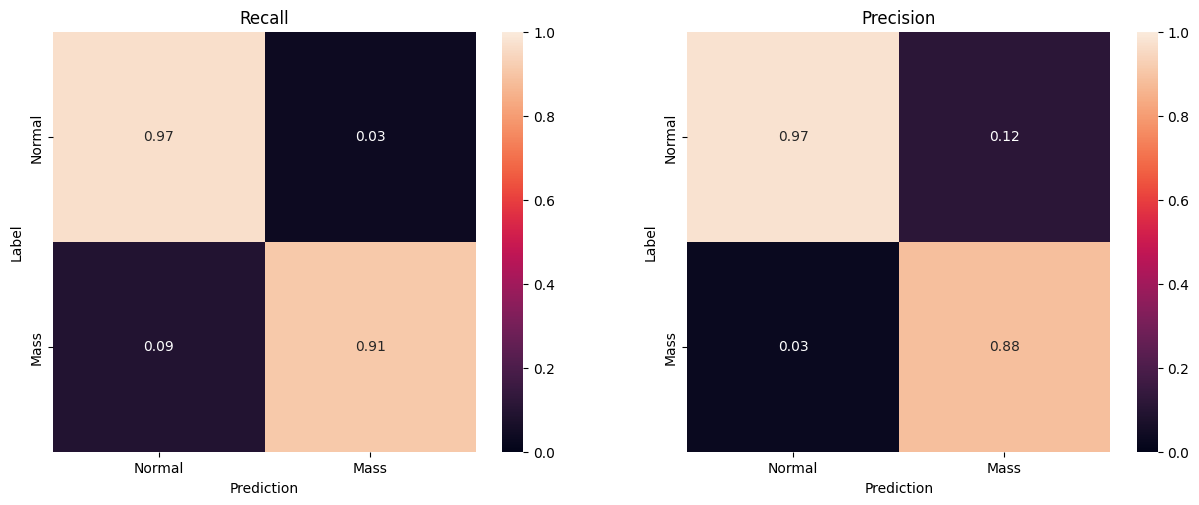

In [18]:
confidence = 0.5

predictions = model.predict(test_ds)
predictions[predictions > confidence] = 1
predictions[predictions != 1] = 0
labels = np.concatenate([y for x, y in test_ds])

confusion_matrix = tf.math.confusion_matrix(labels.flatten(), predictions.flatten(), num_classes=2)
print(confusion_matrix)

classes = ["Normal", "Mass"]

def show_confusion_matrix(cm, labels, norm_axis, title):
    sum = cm.numpy().sum(axis=norm_axis)
    if norm_axis == 1:
        sum = sum[:, np.newaxis]
        
    cmn = cm.numpy().astype('float') / sum
    sns.heatmap(
        cmn, 
        xticklabels=labels, 
        yticklabels=labels, 
        annot=True, 
        fmt='.2f',
        vmin=0.0,
        vmax=1.0,
    )
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title(title)

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
show_confusion_matrix(confusion_matrix, classes, 1, 'Recall')
plt.subplot(2, 2, 2)
show_confusion_matrix(confusion_matrix, classes, 0, 'Precision')
plt.show()

## Show predictions

2023-05-23 11:05:12.329500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [378,3]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 192ms/step


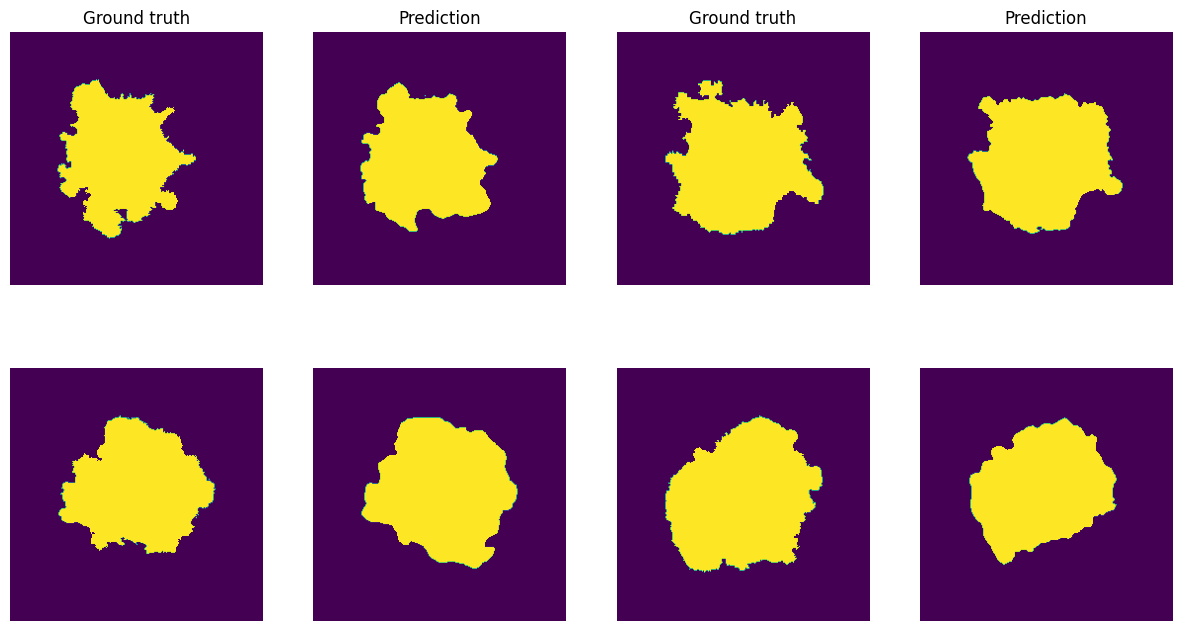

In [19]:
num_rows = 2
num_cols = 2

def display_mask(image):
    mask = tf.cast(image + (1 - confidence), tf.uint8)
    plt.imshow(mask)

for x, y in test_ds.take(1):
    for i in range(1, num_rows * num_cols * 2 + 1, 2):
        plt.subplot(num_rows, num_cols * 2, i)

        test_image = x[i]
        if i <= num_cols * 2:
            plt.title("Ground truth")
        plt.imshow(tf.keras.utils.array_to_img(y[i]))
        plt.axis('off')

        plt.subplot(num_rows, num_cols * 2, i + 1)
        mask = model.predict(np.expand_dims(test_image, 0))[0]
        if i <= num_cols * 2:
            plt.title("Prediction")
        display_mask(mask)
        plt.axis('off')

plt.gcf().set_size_inches(15, 8)
plt.show()


In [14]:
def draw_roc_curve(labels, predictions):
    fpr, tpr, threshold = metrics.roc_curve(labels, predictions)
    auc = metrics.auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [5]:
new_model = tf.keras.models.load_model('../../application/public/models/segmentation-trunet', custom_objects={"iou_loss": iou_loss, "iou_coef": iou_coef})

2023-05-25 12:49:17.020919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'images' with dtype float and shape [?,256,256,3]
	 [[{{node images}}]]
2023-05-25 12:49:17.023821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,256,256,3]
	 [[{{node Placeholder}}]]
2023-05-25 12:49:17.028837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'patch' with dtype float and shape [?,?,192]
	 [[{{node patc

In [16]:
predictions = new_model.predict(test_ds)

24/24 [==============================] - 97s 4s/step


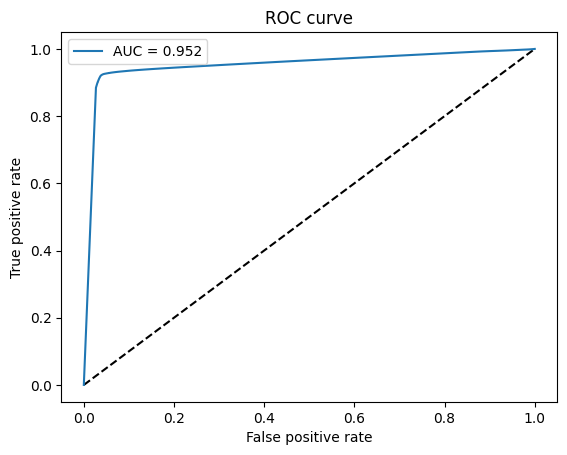

In [17]:
draw_roc_curve(labels.flatten(), predictions.flatten())

## Export model

In [21]:
model.save("./models/exported_model")